# NASA FIRMS API

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic
import seaborn as sns

In [3]:
# 75e917639662d99e126af79e621bbd9d

In [4]:
MAP_KEY = '75e917639662d99e126af79e621bbd9d'
urlt = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY

dft = pd.read_json(urlt,  typ='series')
display(dft)

transaction_limit             5000
current_transactions             0
transaction_interval    10 minutes
dtype: object

In [18]:
# URLs for data sources
us_modis_url = f'https://firms.modaps.eosdis.nasa.gov/api/country/csv/{MAP_KEY}/MODIS_SP/USA/10/2023-06-07'
can_modis_url = f'https://firms.modaps.eosdis.nasa.gov/api/country/csv/{MAP_KEY}/MODIS_SP/CAN/10/2023-06-07'
usa_viirs_url = f'https://firms.modaps.eosdis.nasa.gov/api/country/csv/{MAP_KEY}/VIIRS_SNPP_SP/USA/10/2023-06-07'
can_viirs_url = f'https://firms.modaps.eosdis.nasa.gov/api/country/csv/{MAP_KEY}/VIIRS_SNPP_SP/CAN/10/2023-06-07'

#Load data from URLs
us_modis = pd.read_csv(us_modis_url)
can_modis = pd.read_csv(can_modis_url)
usa_viirs = pd.read_csv(usa_viirs_url)
can_viirs = pd.read_csv(can_viirs_url)

print(us_modis.shape)
print(can_modis.shape)
print(usa_viirs.shape)
print(usa_viirs.shape)

(1760, 16)
(21934, 16)
(9075, 16)
(9075, 16)


In [20]:
# Target coordinates choosen to display wildfires
target_coords = [
    (48.8101, -76.3605),
    (53.08228, -75.44976),
    (52.7008, -73.5289),
    (50.470, -74.259)
]

In [22]:
# check if a point is close to any target coordinate
def is_close_to_target(lat, lon, max_distance_km=50):
    for target in target_coords:
        distance = geodesic((lat, lon), target).km
        if distance <= max_distance_km:
            return True
    return False
    
# checks if a single point is close to any of the target coordinates within 50km

In [24]:
# filter data within certain distance from target coordinates
def filter_by_proximity(data, lat_col, lon_col, target_coords, max_distance_km=50):
    filtered_data = []
    for _, row in data.iterrows():
        point = (row[lat_col], row[lon_col])
        for target in target_coords:
            distance = geodesic(point, target).km
            if distance <= max_distance_km:
                filtered_data.append(row)
                break
    return pd.DataFrame(filtered_data)

In [26]:
# Convert acquisition date columns to datetime
us_modis['acq_date'] = pd.to_datetime(us_modis['acq_date'])
can_modis['acq_date'] = pd.to_datetime(can_modis['acq_date'])
usa_viirs['acq_date'] = pd.to_datetime(usa_viirs['acq_date'])
can_viirs['acq_date'] = pd.to_datetime(can_viirs['acq_date'])

# Filter data within date range
start_date = '2023-05-01'
end_date = '2023-06-30'

modis_data_us_filtered = us_modis[(us_modis['acq_date'] >= start_date) & (us_modis['acq_date'] <= end_date)]
modis_data_ca_filtered = can_modis[(can_modis['acq_date'] >= start_date) & (can_modis['acq_date'] <= end_date)]
viirs_data_us_filtered = usa_viirs[(usa_viirs['acq_date'] >= start_date) & (usa_viirs['acq_date'] <= end_date)]
viirs_data_ca_filtered = can_viirs[(can_viirs['acq_date'] >= start_date) & (can_viirs['acq_date'] <= end_date)]

# Filter data by proximity to targeted coordinates
filtered_modis_us = filter_by_proximity(modis_data_us_filtered, 'latitude', 'longitude', target_coords)
filtered_modis_ca = filter_by_proximity(modis_data_ca_filtered, 'latitude', 'longitude', target_coords)
filtered_viirs_us = filter_by_proximity(viirs_data_us_filtered, 'latitude', 'longitude', target_coords)
filtered_viirs_ca = filter_by_proximity(viirs_data_ca_filtered, 'latitude', 'longitude', target_coords)

# Combine filtered data for analysis
modis_combined_limited = pd.concat([filtered_modis_us, filtered_modis_ca])
viirs_combined_limited = pd.concat([filtered_viirs_us, filtered_viirs_ca])

In [27]:
modis_combined_limited.columns

Index(['country_id', 'latitude', 'longitude', 'brightness', 'scan', 'track',
       'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence',
       'version', 'bright_t31', 'frp', 'daynight', 'type'],
      dtype='object')

In [28]:
modis_combined_limited.to_csv('./Data/NASA Wildfires/modis_combined_limited.csv', index=False)
viirs_combined_limited.to_csv('./Data/NASA Wildfires/viirs_combined_limited.csv', index=False)

modis_combined_limited = pd.read_csv('./Data/NASA wildfires/modis_combined_limited.csv')
viirs_combined_limited = pd.read_csv('./Data/NASA wildfires/viirs_combined_limited.csv')

In [29]:
modis_date_max = modis_combined_limited['acq_date'].max()
modis_date_min = modis_combined_limited['acq_date'].min()

viirs_date_max = viirs_combined_limited['acq_date'].max()
viirs_date_min = viirs_combined_limited['acq_date'].min()

(modis_date_min, modis_date_max), (viirs_date_min, viirs_date_max)

# API can only fetch data for 10 days at a time from selected date.

((Timestamp('2023-06-07 00:00:00'), Timestamp('2023-06-16 00:00:00')),
 (Timestamp('2023-06-07 00:00:00'), Timestamp('2023-06-16 00:00:00')))

In [47]:
def process_data(df, is_modis=True):
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    
    # Days around June 7th, 2023 (+-3 days)
    start_date = '2023-06-04'
    end_date = '2023-06-10'
    df = df[(df['acq_date'] >= start_date) & (df['acq_date'] <= end_date)].copy()  # Create a copy here
    
    # Filter by proximity
    df.loc[:, 'is_close'] = df.apply(lambda row: is_close_to_target(row['latitude'], row['longitude']), axis=1)
    df = df[df['is_close']]
    
    # Select relevant columns
    if is_modis:
        cols = ['latitude', 'longitude', 'acq_date', 'acq_time', 'frp', 'confidence', 'brightness', 'satellite']
    else:
        cols = ['latitude', 'longitude', 'acq_date', 'acq_time', 'frp', 'bright_ti4', 'satellite']
    
    return df[cols]

In [49]:
# Process and filter data for both MODIS and VIIRS
modis_ca_filtered = process_data(can_modis)
modis_us_filtered = process_data(us_modis)
viirs_ca_filtered = process_data(can_viirs, is_modis=False)
viirs_us_filtered = process_data(usa_viirs, is_modis=False)

# Combine filtered data
modis_combined = pd.concat([modis_ca_filtered, modis_us_filtered])
viirs_combined = pd.concat([viirs_ca_filtered, viirs_us_filtered])

print("Filtered MODIS Data:")
display(modis_combined.head())

print("Filtered VIIRS Data:")
display(viirs_combined.head())

Filtered MODIS Data:


,latitude,longitude,acq_date,acq_time,frp,confidence,brightness,satellite
0,52.8375,-73.6901,2023-06-07,105,156.1,84,314.1,Terra
35,48.5042,-76.7348,2023-06-07,241,38.2,100,334.8,Terra
36,48.5131,-76.7375,2023-06-07,241,30.2,75,330.2,Terra
37,48.5711,-76.0567,2023-06-07,241,9.3,57,303.7,Terra
38,48.5809,-76.2036,2023-06-07,241,141.0,100,374.8,Terra


Filtered VIIRS Data:


,latitude,longitude,acq_date,acq_time,frp,bright_ti4,satellite
1,52.70022,-73.53815,2023-06-07,552,1.51,302.90,N
2,52.70024,-73.52988,2023-06-07,552,1.51,313.64,N
3,52.71918,-73.49647,2023-06-07,552,2.94,319.40,N
4,52.72164,-73.49215,2023-06-07,552,1.98,306.66,N
5,52.72496,-73.71776,2023-06-07,552,2.65,332.59,N


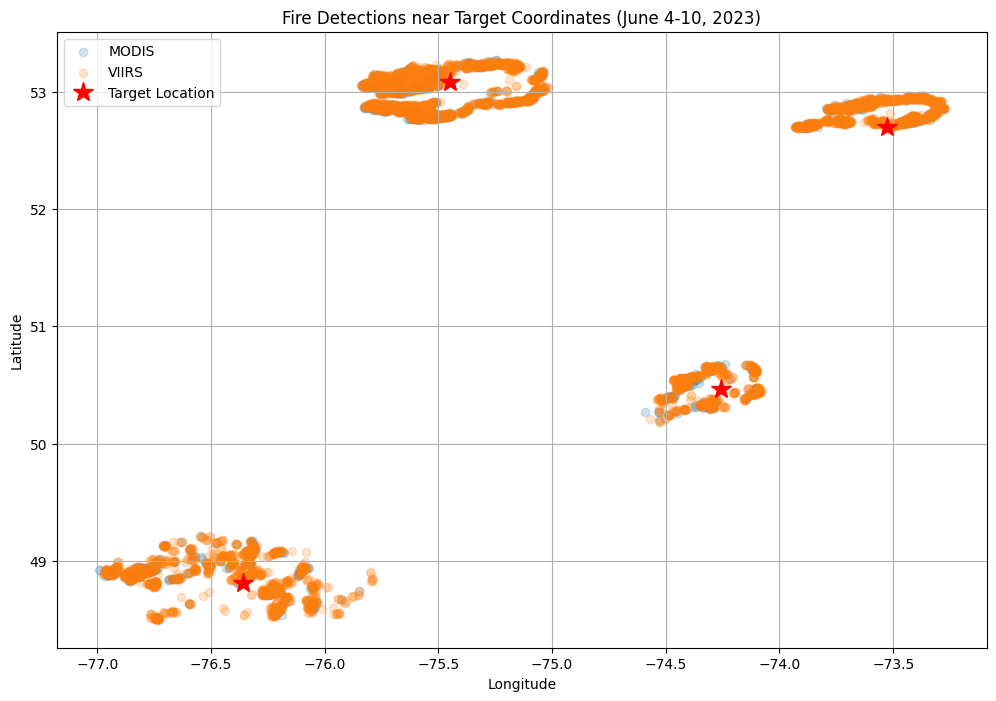

Number of MODIS detections: 1001
Number of VIIRS detections: 6417


In [50]:
# Scatter plot of fire locations
plt.figure(figsize=(12, 8))
plt.scatter(modis_combined['longitude'], modis_combined['latitude'], alpha=0.2, label='MODIS')
plt.scatter(viirs_combined['longitude'], viirs_combined['latitude'], alpha=0.2, label='VIIRS')

for coord in target_coords:
    plt.plot(coord[1], coord[0], 'r*', markersize=15, label='Target Location' if coord == target_coords[0] else "")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fire Detections near Target Coordinates (June 4-10, 2023)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of MODIS detections: {len(modis_combined)}")
print(f"Number of VIIRS detections: {len(viirs_combined)}")

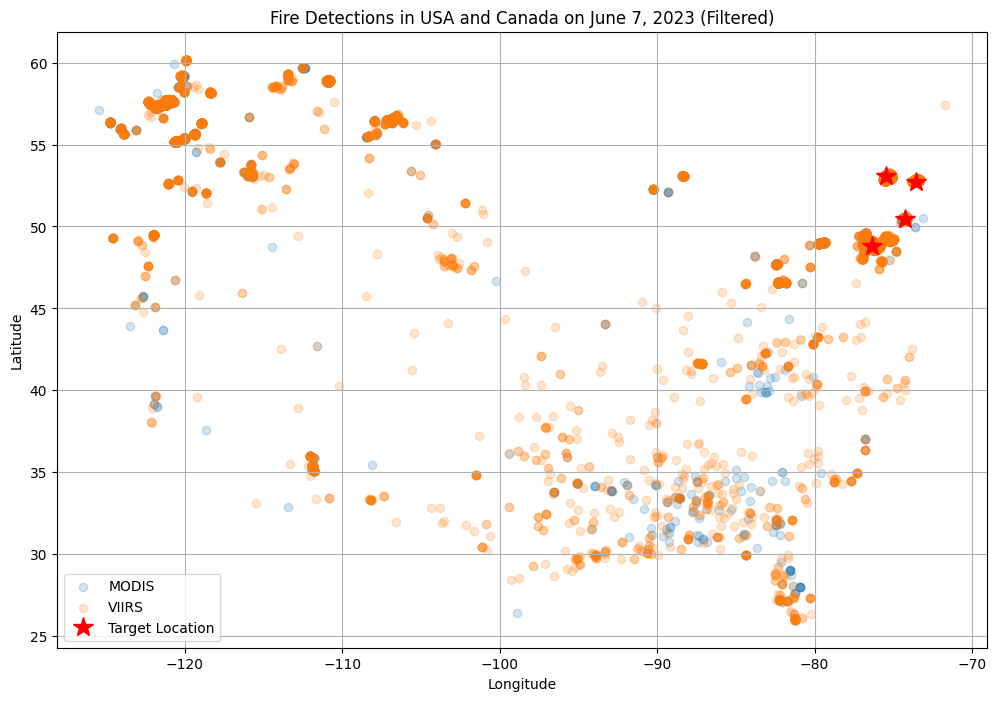

Number of MODIS detections on June 7, 2023 after filtering: 1748
Number of VIIRS detections on June 7, 2023 after filtering: 9419


In [51]:
# Define boundaries 
min_latitude = 25    # Minimum latitude to keep
min_longitude = -140 # Minimum longitude to keep

# Filter data for June 7th, 2023, without outliers
modis_filtered = modis_all_june7[(modis_all_june7['latitude'] >= min_latitude) & (modis_all_june7['longitude'] >= min_longitude)]
viirs_filtered = viirs_all_june7[(viirs_all_june7['latitude'] >= min_latitude) & (viirs_all_june7['longitude'] >= min_longitude)]

plt.figure(figsize=(12, 8))

plt.scatter(modis_filtered['longitude'], modis_filtered['latitude'], alpha=0.2, label='MODIS')
plt.scatter(viirs_filtered['longitude'], viirs_filtered['latitude'], alpha=0.2, label='VIIRS')

# Overlay target locations as a star
for coord in target_coords:
    plt.plot(coord[1], coord[0], 'r*', markersize=15, label='Target Location' if coord == target_coords[0] else "")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fire Detections in USA and Canada on June 7, 2023 (Filtered)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of MODIS detections on June 7, 2023 after filtering: {len(modis_filtered)}")
print(f"Number of VIIRS detections on June 7, 2023 after filtering: {len(viirs_filtered)}")


In [ ]:
# The above shows MODIS AND VIIRS results across USA and CANADA